# Downloading the OpenAQ Air Pollution dataset

In [1]:
# Uncomment below to download the Open AQ dataset from Amazon
#!pip install awscli
#!~/.local/bin/aws s3 cp --no-sign-request s3://openaq-data-archive/records/csv.gz/ dataset --recursive

# Now that the download is over, let's do some Air Pollution Data Exploration!

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd 
import os
import sys
from pyspark.sql import SparkSession
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

from pyspark import SparkContext
from pyspark.sql import SparkSession

# Creating a SparkContext instance 
sc = SparkContext()

# Creating a spark session
spark = SparkSession.builder.appName('232 Project').getOrCreate()

# Files from AWS were in csv.gz formats. We need to decompress these files to csv files.

In [34]:
# Create a folder to put the unzipped csv files
#!mkdir -p combined_csv_files

In [37]:
# This will find the .csv.gz files and unzip them then copy that to the folder
#!find ../data/ -type f -name "*.csv" -exec gunzip -c {} \; -exec cp {} combined_csv_files/ \;

In [4]:
# Print the current working directory to get path
import os
current_directory = os.getcwd()
print("Current Directory:", current_directory)

Current Directory: /expanse/lustre/projects/uci150/ameek1


# Creating a DataFrame from the csv files

In [3]:
# This will grab the data someone in the group has already downloaded. 
path = "/expanse/lustre/projects/uci150/cmerry/data/records/csv.gz/country=us"  

from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, DecimalType

schema = StructType([
    StructField("location_id", IntegerType(), True),
    StructField("sensors_id", IntegerType(), True),
    StructField("location", StringType(), True),
    StructField("datetime", TimestampType(), True),
    StructField("lat", DecimalType(precision=10, scale=6), True),
    StructField("lon", DecimalType(precision=10, scale=6), True),
    StructField("parameter", StringType(), True),
    StructField("units", StringType(), True),
    StructField("value", DecimalType(precision=10, scale=6), True),
])


# Read CSV files matching the pattern into a DataFrame
#df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(path)
df = spark.read.option("recursiveFileLookup", "true").csv(path, header=True, schema=schema)

# Pickling the full country=US DataFrame, so we have it later

In [4]:
# pickle the df for later 
import pickle
#df.to_pickle(df_pkl)
df.rdd.saveAsPickleFile("df_pkl_full")

In [18]:
# Had to move a folder inside the pickle files folder 
#!mv /expanse/lustre/projects/uci150/ameek1/df_pkl_full/task_202405070347271836706530796072507_0009_m_004934 ./

# Unpickling the file and creating a DataFrame

In [19]:
# Loading pickled RDD
pickledRDD = spark.sparkContext.pickleFile("/expanse/lustre/projects/uci150/ameek1/df_pkl_full")
schema = StructType([
    StructField("location_id", IntegerType(), True),
    StructField("sensors_id", IntegerType(), True),
    StructField("location", StringType(), True),
    StructField("datetime", TimestampType(), True),
    StructField("lat", DecimalType(precision=10, scale=6), True),
    StructField("lon", DecimalType(precision=10, scale=6), True),
    StructField("parameter", StringType(), True),
    StructField("units", StringType(), True),
    StructField("value", DecimalType(precision=10, scale=6), True),
])
# Converting the RDD to a DataFrame
df = spark.createDataFrame(pickledRDD, schema)


In [20]:
# Showing a portion of the dataframe 
df.show()

+-----------+----------+--------------+-------------------+---------+----------+---------+-----+--------+
|location_id|sensors_id|      location|           datetime|      lat|       lon|parameter|units|   value|
+-----------+----------+--------------+-------------------+---------+----------+---------+-----+--------+
|      10233|     33249|WNVLELSC-10233|2019-09-23 05:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|
|      10233|     33249|WNVLELSC-10233|2019-09-23 06:00:00|35.507224|-82.963625|       o3|  ppm|0.002000|
|      10233|     33249|WNVLELSC-10233|2019-09-23 07:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|
|      10233|     33249|WNVLELSC-10233|2019-09-23 09:00:00|35.507224|-82.963625|       o3|  ppm|0.002000|
|      10233|     33249|WNVLELSC-10233|2019-09-23 10:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|
|      10233|     33249|WNVLELSC-10233|2019-09-23 11:00:00|35.507224|-82.963625|       o3|  ppm|0.002000|
|      10233|     33249|WNVLELSC-10233|2019-09

In [21]:
# Counting the number of rows/observations
df.count()

26541241

## Transforming the datetime col ie splitting the 'datetime' column into date and time and then dropping the 'datetime' column

In [22]:
from pyspark.sql.functions import unix_timestamp, from_unixtime, date_format, col
df = df.withColumn('date', date_format(col('datetime'), 'yyyy-MM-dd')) \
       .withColumn('time', date_format(col('datetime'), 'HH:mm:ss'))
df.show()

+-----------+----------+--------------+-------------------+---------+----------+---------+-----+--------+----------+--------+
|location_id|sensors_id|      location|           datetime|      lat|       lon|parameter|units|   value|      date|    time|
+-----------+----------+--------------+-------------------+---------+----------+---------+-----+--------+----------+--------+
|      10233|     33249|WNVLELSC-10233|2019-09-23 05:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|2019-09-23|05:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 06:00:00|35.507224|-82.963625|       o3|  ppm|0.002000|2019-09-23|06:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 07:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|2019-09-23|07:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 09:00:00|35.507224|-82.963625|       o3|  ppm|0.002000|2019-09-23|09:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 10:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|2019-09-23|10

In [10]:
# Looking at the column features
df.columns

['location_id',
 'sensors_id',
 'location',
 'datetime',
 'lat',
 'lon',
 'parameter',
 'units',
 'value',
 'date',
 'time']

In [11]:
# Printing the schema which was specified above 
df.printSchema()

root
 |-- location_id: integer (nullable = true)
 |-- sensors_id: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- lat: decimal(10,6) (nullable = true)
 |-- lon: decimal(10,6) (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: decimal(10,6) (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)



## Checking for nulls

In [23]:
# Are there any null values? 
from pyspark.sql.functions import isnan, when, count, col

df.select(*(count(when(col(c).isNull(), c)).alias(c) for c in df.columns)).show()

+-----------+----------+--------+--------+---+------+---------+------+------+----+----+
|location_id|sensors_id|location|datetime|lat|   lon|parameter| units| value|date|time|
+-----------+----------+--------+--------+---+------+---------+------+------+----+----+
|          0|         0|       0|       0|  0|166867|        0|166867|166867|   0|   0|
+-----------+----------+--------+--------+---+------+---------+------+------+----+----+



### As seen above here are null values in the longitude, units, and value. The fact that null values were present for units and values may indicate that the sensory was not working. 

In [25]:
# Looking at the dataframe of nulls 
from pyspark.sql.functions import col
# Create a condition to filter rows that contain at least one null value
condition = ' or '.join([f"{column_name} IS NULL" for column_name in df.columns])

# Filter the DataFrame
null_data_df = df.filter(condition)

# Show the result
null_data_df.show()

+-----------+----------+-------------+-------------------+---------+----+---------+-----+-----+----------+--------+
|location_id|sensors_id|     location|           datetime|      lat| lon|parameter|units|value|      date|    time|
+-----------+----------+-------------+-------------------+---------+----+---------+-----+-----+----------+--------+
|       1210|      2169|Geronimo-1210|2016-03-12 08:00:00|32.250000|NULL|-110.9667| NULL| NULL|2016-03-12|08:00:00|
|       1210|      2169|Geronimo-1210|2016-03-12 09:00:00|32.250000|NULL|-110.9667| NULL| NULL|2016-03-12|09:00:00|
|       1210|      2169|Geronimo-1210|2016-03-12 10:00:00|32.250000|NULL|-110.9667| NULL| NULL|2016-03-12|10:00:00|
|       1210|      2169|Geronimo-1210|2016-03-12 11:00:00|32.250000|NULL|-110.9667| NULL| NULL|2016-03-12|11:00:00|
|       1210|      2169|Geronimo-1210|2016-03-12 12:00:00|32.250000|NULL|-110.9667| NULL| NULL|2016-03-12|12:00:00|
|       1210|      2169|Geronimo-1210|2016-03-12 13:00:00|32.250000|NULL

The above shows that in most cases the three likely occur together. 

In [29]:
df = df.na.drop("any")
df.show()

+-----------+----------+--------------+-------------------+---------+----------+---------+-----+--------+----------+--------+
|location_id|sensors_id|      location|           datetime|      lat|       lon|parameter|units|   value|      date|    time|
+-----------+----------+--------------+-------------------+---------+----------+---------+-----+--------+----------+--------+
|      10233|     33249|WNVLELSC-10233|2019-09-23 05:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|2019-09-23|05:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 06:00:00|35.507224|-82.963625|       o3|  ppm|0.002000|2019-09-23|06:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 07:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|2019-09-23|07:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 09:00:00|35.507224|-82.963625|       o3|  ppm|0.002000|2019-09-23|09:00:00|
|      10233|     33249|WNVLELSC-10233|2019-09-23 10:00:00|35.507224|-82.963625|       o3|  ppm|0.003000|2019-09-23|10

# Checking for values below zero

In [30]:
# Seeing if there are any rows where the value of the sensor measurement is below zero 
import pyspark.sql.functions as func

df.filter(func.col("value") < 0).count()

225772

In [31]:
# Look at the dataframe of where the value is less than 0.
# Filter the DataFrame
value_less_0_df = df.filter(col("value") < 0)
value_less_0_df.show()

+-----------+----------+--------------------+-------------------+---------+-----------+---------+-----+---------+----------+--------+
|location_id|sensors_id|            location|           datetime|      lat|        lon|parameter|units|    value|      date|    time|
+-----------+----------+--------------------+-------------------+---------+-----------+---------+-----+---------+----------+--------+
|       1039|     25482| Pinal Air Park-1039|2019-02-06 20:00:00|32.508308|-111.308060|     pm10|µg/m³|-2.000000|2019-02-06|20:00:00|
|       1039|     25482| Pinal Air Park-1039|2019-03-12 21:00:00|32.508308|-111.308060|     pm10|µg/m³|-1.000000|2019-03-12|21:00:00|
|       1504|      2655|    Belle Glade-1504|2016-07-26 18:00:00|26.724167| -80.663055|     pm25|µg/m³|-2.100000|2016-07-26|18:00:00|
|       1504|      2655|    Belle Glade-1504|2016-07-26 19:00:00|26.724167| -80.663055|     pm25|µg/m³|-4.900000|2016-07-26|19:00:00|
|       1504|      2655|    Belle Glade-1504|2016-07-26 20:00:

## The value of a particular parameter should not be zero. Since these measurements are measures of mass in a given volume of air, the concept of negative mass wouldn't make sense and therefore the readings form the sensor should not be negative. This indicates there could be sensor malfunctions, ie. software or calibration errors.

In [32]:
# Filtering to keep all rows with 'value' greater than zero. 
df = df.filter(col("value") > 0)

In [33]:
# Saving as a pickle file for later
df.rdd.saveAsPickleFile("df_pkl_parsed")

In [ ]:
# Loading the parsed pickled RDD
pickledRDD = spark.sparkContext.pickleFile("/expanse/lustre/projects/uci150/ameek1/df_pkl_parsed")
schema = StructType([
    StructField("location_id", IntegerType(), True),
    StructField("sensors_id", IntegerType(), True),
    StructField("location", StringType(), True),
    StructField("datetime", TimestampType(), True),
    StructField("lat", DecimalType(precision=10, scale=6), True),
    StructField("lon", DecimalType(precision=10, scale=6), True),
    StructField("parameter", StringType(), True),
    StructField("units", StringType(), True),
    StructField("value", DecimalType(precision=10, scale=6), True),
])
# Converting the RDD to a DataFrame
df = spark.createDataFrame(pickledRDD, schema)

# Graphing some data (a few samples)

In [47]:
# Filtering for sensor 1803 and parameter 'pm10'
filtered_df = df.filter((df.sensors_id == 1803) & (df.parameter == "pm10")).orderBy("datetime")

In [49]:
# Selecting datetime and value for the graph
pm10_data = filtered_df.select("datetime", "value").collect()

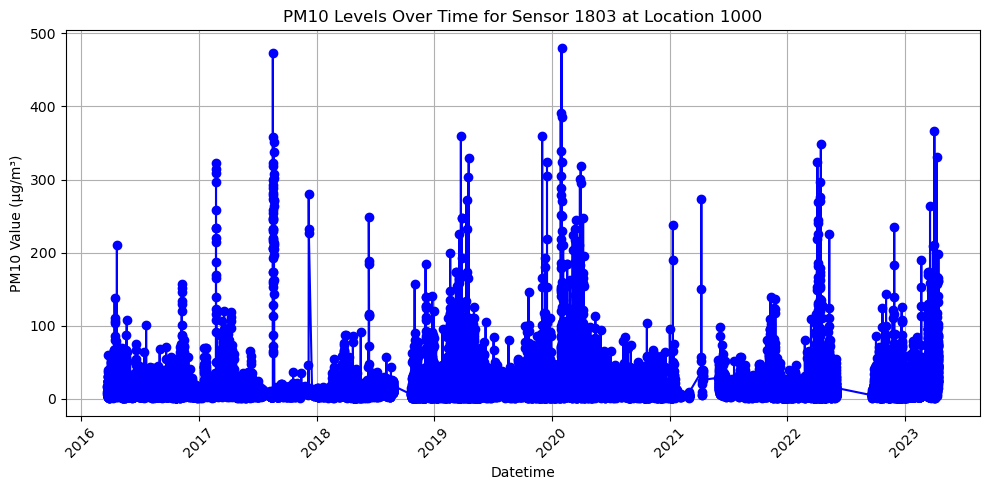

In [50]:
import matplotlib.pyplot as plt

# Extracting separate lists of dates and values and plotting it
dates = [data.datetime for data in pm10_data]
values = [data.value for data in pm10_data]
plt.figure(figsize=(10, 5))
plt.plot(dates, values, marker='o', linestyle='-', color='b')
plt.title("PM10 Levels Over Time for Sensor 1803 at Location 1000")
plt.xlabel("Datetime")
plt.ylabel("PM10 Value (µg/m³)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

From 2016 to 2023, we can see that the largest amounts of pollution for PM10 occurred at the beginning or end of the year. 

### Let's look at the averages of PM10 levels for Sensor 1803

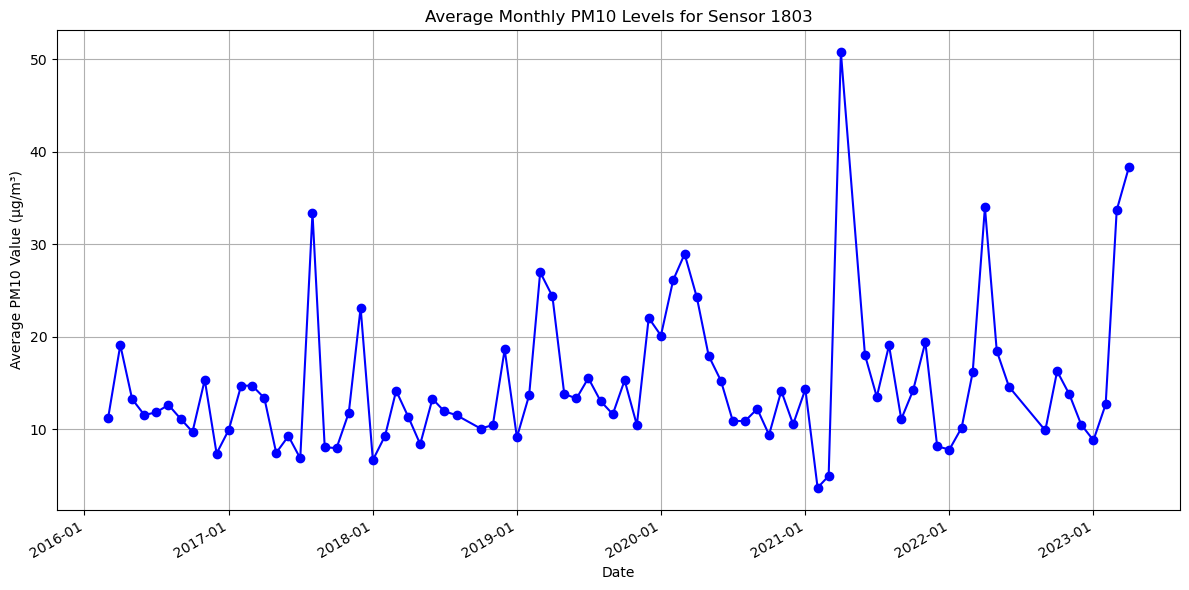

In [51]:
from pyspark.sql.functions import year, month, to_timestamp, avg
# Filtered the DF
filtered_df = df.filter((df.sensors_id == 1803) & (df.parameter == "pm10"))
#filtered_df = filtered_df.withColumn('datetime', to_timestamp('datetime', 'yyyy-MM-dd HH:mm:ss'))
# Add year and month columns for grouping
filtered_df = filtered_df.withColumn('year', year('datetime'))
filtered_df = filtered_df.withColumn('month', month('datetime'))
# Group by year and month, and calculate average values
monthly_avg_data = filtered_df.groupBy('year', 'month').agg(
    avg('value').alias('avg_value')
).orderBy('year', 'month')
monthly_avg_data = monthly_avg_data.collect()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
plt.figure(figsize=(12, 6)) 
dates = [datetime(year=row['year'], month=row['month'], day=1) for row in monthly_avg_data]
values = [row['avg_value'] for row in monthly_avg_data]
plt.plot(dates, values, marker='o', linestyle='-', color='b')
plt.title("Average Monthly PM10 Levels for Sensor 1803")
plt.xlabel("Date")
plt.ylabel("Average PM10 Value (µg/m³)")
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate() 

plt.tight_layout()
plt.show()

# Looking at data with PySpark SQL

In [45]:
# Creating a temporary table to use with PySpark SQL
df.createOrReplaceTempView('pollution')

In [52]:
# Looking at the different number of parameters in the dataset
results = spark.sql("SELECT count(distinct parameter) as Parameter_Count \
                    FROM pollution")
results.show()

+---------------+
|Parameter_Count|
+---------------+
|              9|
+---------------+



In [54]:
# Looking at the sensor counts for each location. 
results = spark.sql("SELECT location_id, sensors_id, count(sensors_id) as Sensor_Count \
                    FROM pollution \
                    GROUP BY location_id, sensors_id \
                    ORDER BY location_id")
results.show()

+-----------+----------+------------+
|location_id|sensors_id|Sensor_Count|
+-----------+----------+------------+
|       1000|      1803|       36050|
|       1000|      1802|       30973|
|       1001|      1804|       20391|
|       1002|      1805|       26916|
|       1003|      1807|       36070|
|       1003|      1806|       26673|
|       1005|      1810|        7626|
|       1006|      1811|       28892|
|       1006|      1812|       21378|
|       1006|      1813|       41336|
|       1008|      1817|       33523|
|       1008|   2888356|        1169|
|       1009|      1818|       36226|
|       1010|      1834|       40699|
|       1010|      1821|       42431|
|       1010|      1819|       40721|
|       1010|     25511|        4936|
|       1011|      1822|        4607|
|       1011|      1820|        4745|
|       1012|      1823|       20130|
+-----------+----------+------------+
only showing top 20 rows



In [60]:
# Looking at the different number of parameters in the dataset
results = spark.sql("SELECT DISTINCT location_id, parameter, sensors_id\
                    FROM pollution")
results.show()

+-----------+---------+----------+
|location_id|parameter|sensors_id|
+-----------+---------+----------+
|       1109|       o3|      1987|
|       1074|       o3|      1926|
|       1503|     pm25|      2653|
|       1023|     pm10|      1846|
|       1054|       o3|      1891|
|       1459|     pm25|      2586|
|       1110|     pm25|      1989|
|       1538|     pm25|      2706|
|       1075|       o3|      1927|
|       1079|     pm25|      1932|
|       1097|     pm25|      5543|
|       1375|       co|      2465|
|       1122|      so2|      2018|
|       1354|     pm25|      2428|
|       1169|       o3|      2099|
|       1354|      so2|      2431|
|       1451|     pm25|      2574|
|       1479|       o3|      2619|
|       1515|       o3|      2673|
|       1080|       o3|      1933|
+-----------+---------+----------+
only showing top 20 rows



# WHO air quality guidelines recommend a maximum exposure of 20 µg/m3 for PM10, 35 µg/m3 for PM2.5, and 0.070 parts per million for O3

## Find the data in the maximum polluted thresholds

In [62]:
## Find the data in the polluted thresholds
results = spark.sql("SELECT * \
                    FROM pollution \
                    WHERE (parameter = 'pm10' AND value > 150) OR (parameter = 'pm25' AND value > 12) OR (parameter = 'o3' AND value > 0.07)")
results.show()
# Could gather insights about what the most polluted areas are 

+-----------+----------+--------------------+-------------------+---------+----------+---------+-----+---------+----------+--------+----+-----+
|location_id|sensors_id|            location|           datetime|      lat|       lon|parameter|units|    value|      date|    time|year|month|
+-----------+----------+--------------------+-------------------+---------+----------+---------+-----+---------+----------+--------+----+-----+
|       1362|      2441|YMCA - Marion Cou...|2021-08-24 05:00:00|29.170799|-82.100800|     pm25|µg/m³|13.100000|2021-08-24|05:00:00|2021|    8|
|       1362|      2441|YMCA - Marion Cou...|2021-08-24 06:00:00|29.170799|-82.100800|     pm25|µg/m³|14.300000|2021-08-24|06:00:00|2021|    8|
|       1362|      2441|YMCA - Marion Cou...|2021-08-24 07:00:00|29.170799|-82.100800|     pm25|µg/m³|15.100000|2021-08-24|07:00:00|2021|    8|
|       1362|      2441|YMCA - Marion Cou...|2021-08-24 08:00:00|29.170799|-82.100800|     pm25|µg/m³|12.900000|2021-08-24|08:00:00|2021

### As we can see this occurs the same day around the same time period - ie. morning to midday 

## Average Value per measurement for each year for each location

In [63]:
results = spark.sql("SELECT location_id, sensors_id, date, parameter, AVG(value) AS avg_value\
                    FROM pollution\
                    GROUP BY parameter, sensors_id, date, location_id")
results.show()

+-----------+----------+----------+---------+------------+
|location_id|sensors_id|      date|parameter|   avg_value|
+-----------+----------+----------+---------+------------+
|       1109|      1987|2019-06-11|       o3|0.0251304348|
|       1109|      1987|2017-08-25|       o3|0.0218095238|
|       1109|      1987|2019-01-08|       o3|0.0176363636|
|      10233|     33249|2020-04-20|       o3|0.0419523810|
|      10233|     33249|2022-03-14|       o3|0.0300000000|
|      10233|     33249|2022-03-21|       o3|0.0270000000|
|       1109|      1987|2017-06-30|       o3|0.0489047619|
|       1109|      1987|2017-02-19|       o3|0.0375000000|
|       1166|      2095|2022-12-15|       o3|0.0339583333|
|       1092|      1959|2017-02-02|       o3|0.0300000000|
|       1039|     25482|2020-01-23|     pm10|5.2500000000|
|       1092|      1959|2017-01-24|       o3|0.0260416667|
|       1092|      1958|2017-05-29|      no2|0.0027916667|
|       1039|     25482|2019-02-18|     pm10|7.000000000